In [1]:
#Importing needed libraries
import os
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


**DATA PREPROCCESSING**

In [2]:
#Dataset Defining
ds = "/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset"
species = [i for i in os.listdir(ds) if "." not in i]
print(f"Species in the dataset: {species}")

Species in the dataset: ['Hourse Mackerel', 'Black Sea Sprat', 'Sea Bass', 'Red Mullet', 'Trout', 'Striped Red Mullet', 'Shrimp', 'Gilt-Head Bream', 'Red Sea Bream']


In [3]:
#Creating empty list for image path and tags
label = []
path = []

#Iterating through the file directories
for dir_name, _, filenames in os.walk(ds):
    for filename in filenames:
        if os.path.splitext(filename)[-1]==".png":
            if dir_name.split()[-1] != 'GT':            
                label.append(os.path.split(dir_name)[-1]) 
                path.append(os.path.join(dir_name, filename))
#Creating dataframe with the obtained image paths and labels
data = pd.DataFrame(columns=["path","label"])
data["path"] = path
data["label"] =  label
data

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
...,...,...
8995,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8996,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8997,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream
8998,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Red Sea Bream


**INFORMATIONS ABOUT DATAFRAME**

In [4]:
#Getting detailed information about Dataframe
def check_df(dataframe, head=5):
    print("####### SHAPE #######")
    print(dataframe.shape)
    print("####### INFO #######")
    print(dataframe.info())
    print("####### Types #######")
    print(dataframe.dtypes)
    print("####### Head #######")
    print(dataframe.head(head))
    print("####### TAIL #######")
    print(dataframe.tail(head))
    print("####### VALUE_COUNTS #######")
    print(dataframe.label.value_counts())

check_df(data)

####### SHAPE #######
(9000, 2)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB
None
####### Types #######
path     object
label    object
dtype: object
####### Head #######
                                                path            label
0  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4  /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
####### TAIL #######
                                                   path          label
8995  /kaggle/input/a-large-scale-fish-dataset/Fi

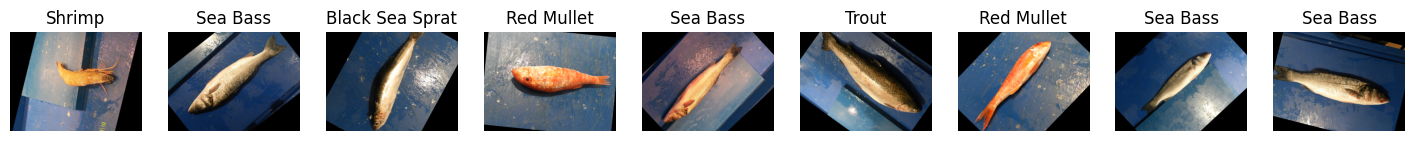

In [5]:
# Function to visualize sample images from the dataset
def display_sample_images(dataframe, samples=9):
    fig, axes = plt.subplots(1, samples, figsize=(18, 4))
    for i in range(samples):
        sample_image = data.sample().iloc[0]
        image = load_img(sample_image['path'])
        axes[i].imshow(image)
        axes[i].set_title(sample_image['label'])
        axes[i].axis('off')
    plt.show()

display_sample_images(data)

**MODEL TRAİNİNG**

In [6]:
train_ds, test_ds = train_test_split(data, test_size=0.2, random_state=1, stratify=data["label"])

In [7]:
# Function to load and preprocess images by resizing them
def preprocess_image(image_path, img_size=(224, 224)):
    image = load_img(image_path, target_size=img_size)
    image_array = img_to_array(image)
    return image_array / 255.0

# Preparing training and testing data
X_train = np.array([preprocess_image(path) for path in train_ds['path']])
y_train = pd.get_dummies(train_ds['label']).values

X_test = np.array([preprocess_image(path) for path in test_ds['path']])
y_test = pd.get_dummies(test_ds['label']).values

print("Training dataset shape:", X_train.shape)
print("Testing dataset shape:", X_test.shape)

Training dataset shape: (7200, 224, 224, 3)
Testing dataset shape: (1800, 224, 224, 3)


In [15]:
data_generator = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

train_data = data_generator.flow_from_directory(
    directory=ds,
    target_size=(224,224),
    batch_size=256,
    subset='training',
    class_mode='categorical'
)

#Validation
validation_data = data_generator.flow_from_directory(
    directory=ds,
    target_size=(224,224),
    batch_size=256,
    subset='validation',
    class_mode='categorical'
)

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


In [10]:
num_classes = len(train_data.class_indices)

**CREATING MODEL**

In [17]:
#Creating the Artificial Neural Network (ANN) model
ann_model = keras.Sequential([
    Input(shape=(224,224,3)),
    Flatten(),
    Dense(1024, activation="relu"),
    Dense(512, activation="relu"),
    Dense(256, activation="relu"),
    Dense(num_classes, activation='softmax')
])

#Compile
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Training
train_ann = ann_model.fit(
    train_data,
    epochs=10,
    validation_data=validation_data
)

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 283s 5s/step - accuracy: 0.1387 - loss: 32.1419 - val_accuracy: 0.2158 - val_loss: 2.4401
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 327s 5s/step - accuracy: 0.4425 - loss: 1.5875 - val_accuracy: 0.3808 - val_loss: 1.8450
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 261s 4s/step - accuracy: 0.5927 - loss: 1.1166 - val_accuracy: 0.5739 - val_loss: 1.3302
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 274s 5s/step - accuracy: 0.6845 - loss: 0.8867 - val_accuracy: 0.5225 - val_loss: 1.2671
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 259s 4s/step - accuracy: 0.7162 - loss: 0.7783 - val_accuracy: 0.6064 - val_loss: 1.0675
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 243s 4s/step - accuracy: 0.7659 - loss: 0.6610 - val_accuracy: 0.5911 - val_loss: 1.2068
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.7799 - loss: 0.6047 - val_accuracy: 0.6056 - val_loss: 1.2516
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 246s 4s/step - accuracy: 0.8183 - loss: 0.5065 - val_accuracy: 0.6828 - 

**VISUALIZING**


57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step


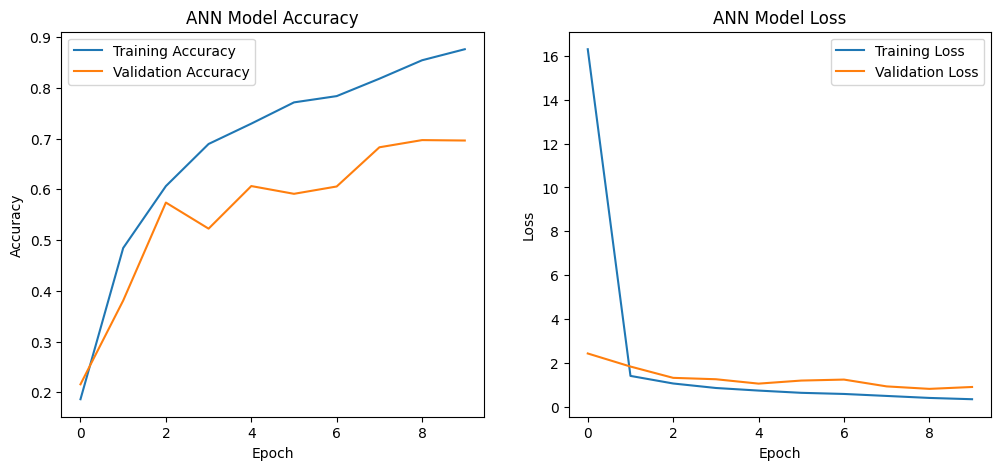

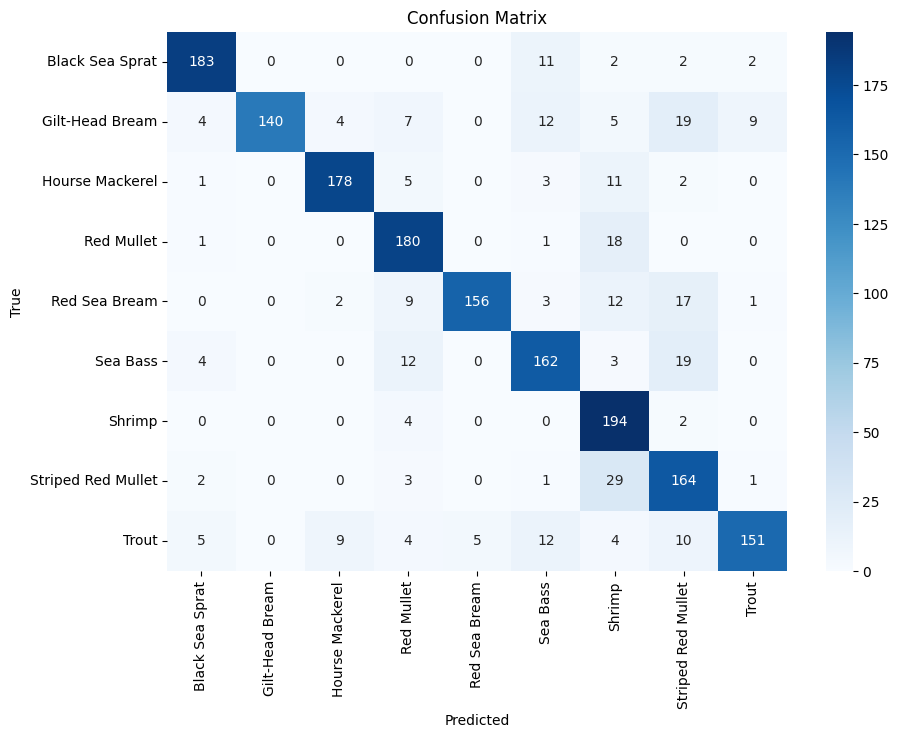

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       200
           1       1.00      0.70      0.82       200
           2       0.92      0.89      0.91       200
           3       0.80      0.90      0.85       200
           4       0.97      0.78      0.86       200
           5       0.79      0.81      0.80       200
           6       0.70      0.97      0.81       200
           7       0.70      0.82      0.75       200
           8       0.92      0.76      0.83       200

    accuracy                           0.84      1800
   macro avg       0.86      0.84      0.84      1800
weighted avg       0.86      0.84      0.84      1800



In [20]:
# Visualizing validation metrics for the ANN model
plt.figure(figsize=(12, 5))

# Plotting validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_ann.history['accuracy'], label='Training Accuracy')
plt.plot(train_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title('ANN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting validation loss
plt.subplot(1, 2, 2)
plt.plot(train_ann.history['loss'], label='Training Loss')
plt.plot(train_ann.history['val_loss'], label='Validation Loss')
plt.title('ANN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()



# Confusion Matrix

# Making predictions on the test dataset
y_pred = ann_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generating the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_data.class_indices.keys(), 
            yticklabels=train_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print(classification_report(y_true_classes, y_pred_classes))